# Task 4: Mitigating Bias (Decision Tree)

In this notebook, you will train a Decision Tree model to predict the `prior_hiring_decision` target variable. You should compare its performance (Accuracy and Fairness) to the Logistic Regression baseline.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Load Data
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

print("Training Shape:", train_df.shape)

Training Shape: (30000, 13)


## Preprocessing Mitigation

In [ ]:
# TODO: Train Decision Tree and Report Accuracy + Fairness Metrics
import importlib
import utils
importlib.reload(utils)
from utils import preprocess_data, compute_reweighing_weights  # since notebook is in src/, this is correct

data, clf = preprocess_data(train_df, val_df, test_df, 
                            sensitive_col='is_white', 
                            target=DecisionTreeClassifier(max_depth=5))
weight = compute_reweighing_weights(data['sensitive_val'], data['y_train'])
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
sensitive_val = data['sensitive_val']



Using Features: ['Age', 'Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Hours_Per_Week', 'Sex', 'Place_Of_Birth', 'interview_score', 'cv_assessment_score']
Numerical: ['Age', 'Hours_Per_Week', 'interview_score', 'cv_assessment_score']
Categorical: ['Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Sex', 'Place_Of_Birth']


In [ ]:
# Train Classifier
clf.fit(X_train, y_train, sample_weight=weight)
# Validate Classifier
y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)[:, 1]

## Post-processing Mitigation

In [ ]:
# Apply different thresholds for different groups
tau_a = 0.5
tau_b = 0.5
y_pred_post_process = np.where(
    (sensitive_val == "group_a") & (y_pred_proba >= tau_a) |
    (sensitive_val == "group_b") & (y_pred_proba >= tau_b),
    1,
    0
)

## Results for Pre-processing

In [ ]:
importlib.reload(utils)
from utils import plot_roc_curve, fairness_metrics


accuracy = accuracy_score(y_val, y_pred)
fairness_results, fairness_gaps = fairness_metrics(y_val, y_pred, sensitive_val, min_group_size=30)

print("Validation Accuracy:", accuracy)
for group, result in fairness_results.items():
    print(f"Group {group}")
    for metric, value in result.items():
        print(f"  {metric}: {value}")
for metric, gap in fairness_gaps.items():
    print(f"{metric} Gap: {gap}")



# plot_roc_curve(y_val, y_pred_proba, title="Decision Tree Validation ROC Curve")
# plot_roc_curve(y_val, y_pred_proba, sensitive_val, title="Decision Tree Validation ROC Curve")


Validation Accuracy: 0.7357
Group 0
  n: 3756
  selection_rate_P(yhat=1|A): 0.3059105431309904
  TPR_P(yhat=1|Y=1,A): 0.5687203791469194
  FPR_P(yhat=1|Y=0,A): 0.1355857832382624
  TNR: 0.8644142167617376
  FNR: 0.4312796208530806
  TP: 840
  FP: 309
  TN: 1970
  FN: 637
Group 1
  n: 6244
  selection_rate_P(yhat=1|A): 0.505285073670724
  TPR_P(yhat=1|Y=1,A): 0.7193140794223827
  FPR_P(yhat=1|Y=0,A): 0.26164383561643834
  TNR: 0.7383561643835617
  FNR: 0.2806859205776173
  TP: 2391
  FP: 764
  TN: 2156
  FN: 933
DP_gap_|P(yhat=1|A=1)-P(yhat=1|A=0)| Gap: 0.19937453053973353
EO_gap_|TPR(A=1)-TPR(A=0)| Gap: 0.15059370027546326
FPR_gap_|FPR(A=1)-FPR(A=0)| Gap: 0.12605805237817594
EOD_gap_max(TPR_gap,FPR_gap) Gap: 0.15059370027546326


## Results for Pre-processing + Post-processing Mitigation

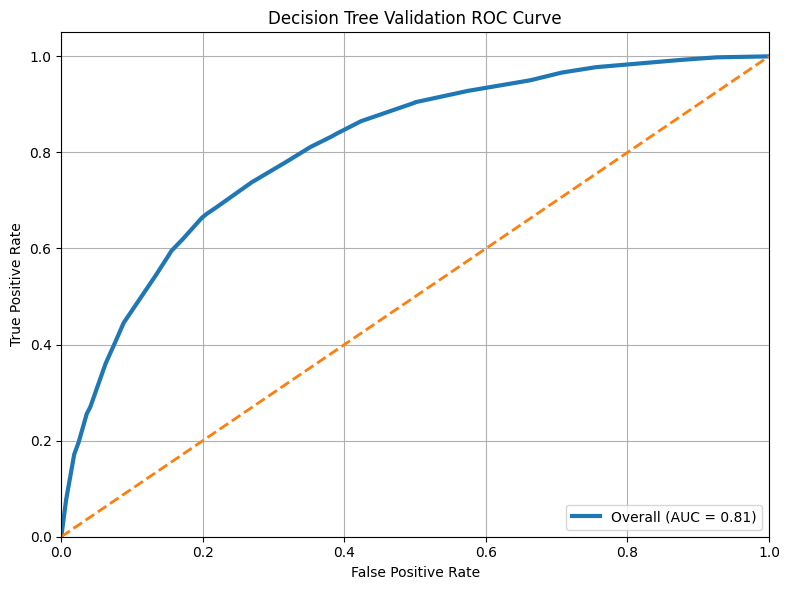

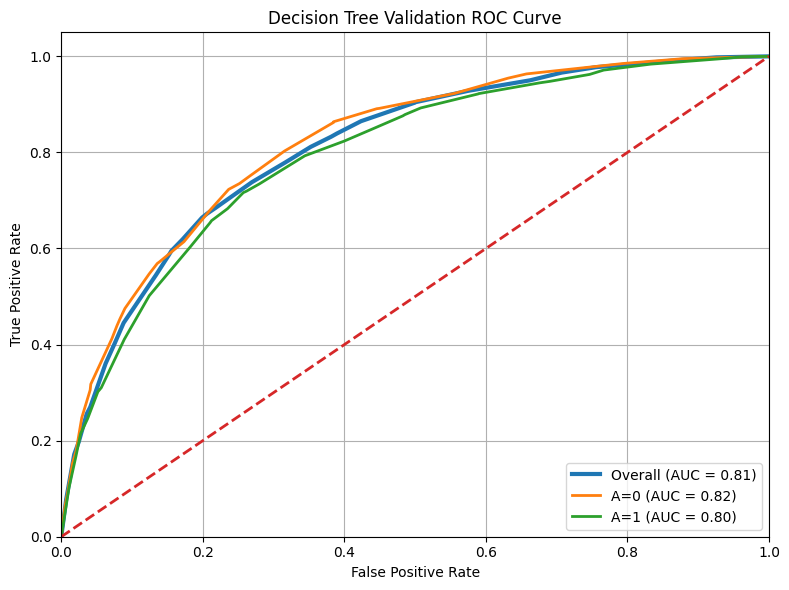

In [ ]:
importlib.reload(utils)
from utils import plot_roc_curve, fairness_metrics


accuracy = accuracy_score(y_val, y_pred_post_process)
fairness_results, fairness_gaps = fairness_metrics(y_val, y_pred_post_process, sensitive_val, min_group_size=30)

print("Validation Accuracy:", accuracy)
for group, result in fairness_results.items():
    print(f"Group {group}")
    for metric, value in result.items():
        print(f"  {metric}: {value}")
for metric, gap in fairness_gaps.items():
    print(f"{metric} Gap: {gap}")
